# Tensorflow - Pneumonia detection

In this notebook, you can find the equivalent of the Scikit-learn notebook but with the use of deep learning with Tensorflow. The detection of pneumonia from images is a classification. The CNN models are known to be very efficient to work on images.

1. Image processing
2. Data augmentation
3. A basic model: MLP
4. The CNN model
5. Analysis and test of the CNN model
6. Optimization of the model

## **1. Setup and Load Data**

### **1.1 Install dependencies and Setup**

In [ ]:
# CPU
%pip install tensorflow-cpu matplotlib sklearn seaborn chardet scipy pandas numpy

In [ ]:
# GPU
%pip install "tensorflow==2.10.*" matplotlib sklearn seaborn chardet scipy pandas numpy

In [1]:
# acess to our files
import os
import json

# manipulate our data
import numpy as np
import pandas as pd

# build our model
import tensorflow as tf
from tensorflow import keras
from keras import layers

# visualize
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# check if your gpu is detected
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### **1.2 Load Data**

Due to the poor size of validation dataset (~10), we moved validation dataset to the training dataset and we will pick ~10-20% of the training dataset as validation data


- For data augmentation images, check more_data notebook

Training size:
- NORMAL: 1341 * 2 = 2682
- PNEUMONIA: 3875 *2 = 7750
Total = 10468

test size: 640

In [2]:
# Define the paths to the training and test directories
train_data_dir = '../data/chest_Xray/train'
test_data_dir = '../data/chest_Xray/test'

# Define the path to the directory containing the augmented images
aug_data_dir = '../data/chest_Xray/train_augmented'
 

# Image size and batch size
img_height, img_width = 180, 180
batch_size = 32

# load and preprocess the dataset and store them in a batch (32 images per 32)
print('TRAINING_DS:')
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="both",
    color_mode="grayscale",
    seed=0,
)

# load class_names
class_names = train_ds.class_names
num_classes = len(class_names) # used for the last layer of models (the output): it is 2 ["NORMAL", "PNEUMONIA"]


# Load augmented data
print('TRAINING_AUGMENTED_DS:')
train_aug_ds, val_aug_ds = tf.keras.utils.image_dataset_from_directory(
    aug_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    validation_split=0.2,
    subset="both",
    seed=0,
)

print('TEST_DS:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    seed=0,
)

TRAINING_DS:
Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Using 1043 files for validation.
TRAINING_AUGMENTED_DS:
Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Using 1043 files for validation.
TEST_DS:
Found 640 files belonging to 2 classes.


 Every objects are a tensorflow.data.Dataset and every dataset have:

- Batchs: every batch have 32 images
- images are 180x180

In [5]:
# Get informations of our datasets
print("DATASETS:")
print(train_ds)
print(val_ds)
print(test_ds)
print(class_names)
print("Number of elements in the training_dataset:", train_ds.cardinality().numpy() * batch_size)
print("Number of elements in the validation_dataset:", val_ds.cardinality().numpy() * batch_size)
print("Number of elements in the test_dataset:", test_ds.cardinality().numpy() * batch_size)

DATASETS:
<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['NORMAL', 'PNEUMONIA']
Number of elements in the training_dataset: 8384
Number of elements in the validation_dataset: 2112
Number of elements in the test_dataset: 640


shape != (32, 180, 180, 1) because some batches are incomplete, you can check with that:
We have 2 of 13 batch_size and the rest of 32

It is better to have batches of the same size, it is not always possible or practical, and having a few batches of a different size is generally acceptable. However, if you have a large number of batches with very different sizes, you may want to consider adjusting the batch size or resampling the data to achieve more uniform batch sizes.

In [41]:
for batch in train_ds:
    inputs, labels = batch
    print(tf.shape(inputs))

tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1],

### **1.3 Visualize Data**

With the library matplotlib, we can visualize our dataset

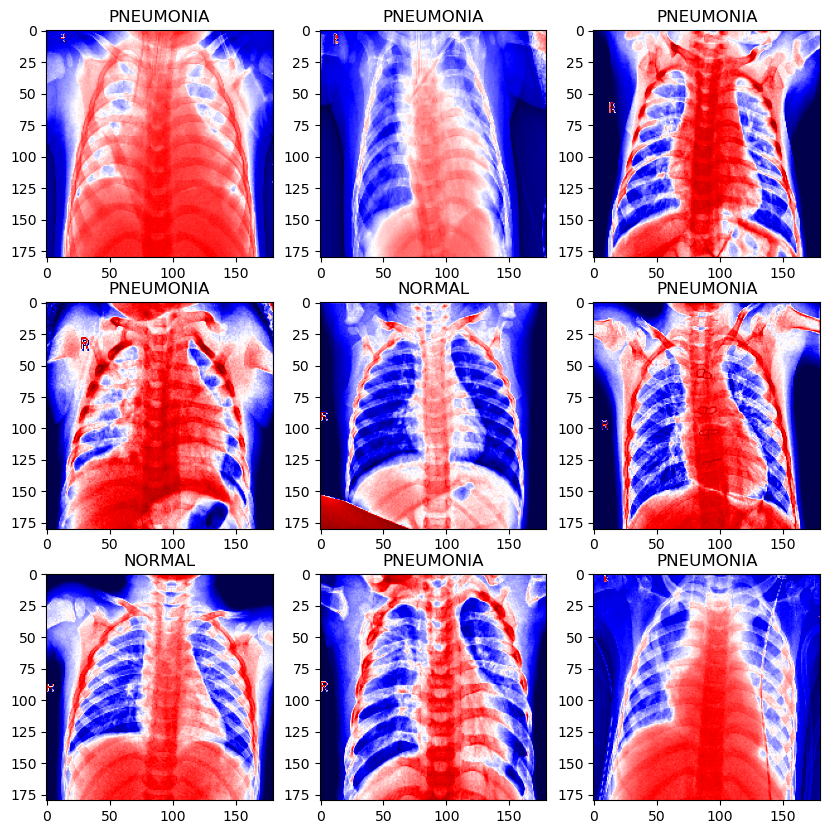

In [23]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap="seismic") # cmap works only with grayscale
        plt.title(class_names[labels[i]])

## **2. Deep Model: Multi-Layer Perceptron (MLP)**
### **2.1 Build MLP**

MLP stands for Multi-Layer Perceptron, which is a type of artificial neural network. An MLP consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function.

MLP uses a supervised learning technique called backpropagation for training. It's a class of feedforward artificial neural network, meaning that data travels in one direction from input to output.

While it can be used for image classification tasks, it is generally less effective than CNNs because it does not exploit the spatial structure and local patterns in images. Moreover, MLPs typically require more parameters and are more prone to overfitting compared to CNNs, especially when dealing with larger images.

- **Rescaling**:
- **Flatten**:
- **Dense**:

**Activation fonction:**

For classification tasks, the two most common activation functions are softmax and sigmoid.

- `Softmax`: The softmax activation function is used for multi-class classification problems where each input can belong to one of multiple classes. It calculates the probabilities for each class, and the probabilities sum to 1. It is the recommended activation function for multi-class classification tasks.

- `Sigmoid`: The sigmoid activation function is typically used for binary classification problems, where each input can belong to one of two classes. The sigmoid function outputs a probability value between 0 and 1, representing the likelihood of an input belonging to the positive class. It is the recommended activation function for binary classification tasks.

Using the correct activation function for your specific problem will generally result in better model performance.

In [36]:
# Build our model
model = tf.keras.Sequential([
    # input
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    # hidden layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # output
    layers.Dense(num_classes, activation='softmax'), 
])

Compiling the model in Keras is an essential step before training it. When you compile a model, you're setting up the learning process, which is done by defining key aspects of the training mechanics.

Here's what happens when you compile a model:

- **Optimization Method is Selected**: The optimizer is the algorithm that adjusts the weights and biases during training. Examples include Adam, RMSprop, and Stochastic Gradient Descent (SGD). These optimizers use the backpropagation algorithm to minimize the model's error function.

- **Loss Function is Selected**: The loss function, also known as the objective function, is the function that the model will aim to minimize during training. The choice of loss function depends on the problem at hand (e.g., binary cross-entropy for binary classification, categorical cross-entropy for multi-class classification, mean squared error for regression).

- **Metrics for Evaluation are Selected**: These are the criteria that we use to evaluate the performance of the model. Examples of metrics include accuracy, precision, recall, and F1 score. These metrics are not used for training the model, but provide additional context for how well the model is performing.

In [37]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
# view all the layers of the network
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 1)       0         
                                                                 
 flatten (Flatten)           (None, 32400)             0         
                                                                 
 dense (Dense)               (None, 128)               4147328   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4,147,586
Trainable params: 4,147,586
Non-trainable params: 0
_________________________________________________________________


### 2.2 **Train**

Once our model build, we can train with our training dataset.

the fit method in Keras is used to train the model for a fixed number of epochs (iterations on a dataset). Here's what each of the parameters does:

**train_ds**: This is your training data, which the model learns from. This should be a tuple of inputs and target outputs, or a tf.data dataset.

**validation_data**: This is the data that the model doesn't learn from but uses to evaluate its performance after each epoch. This can be used to check if the model is overfitting or underfitting. This should be in the same format as your training data.

**epochs**: This is the number of times the learning algorithm will work through the entire training dataset. For example, if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete one epoch.

**callbacks**: These are functions that can be applied at certain stages of the training process, such as at the end of each epoch. In this case, you're using early stopping, which is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. This is done by stopping the training process when the performance on the validation set starts to degrade (i.e., the loss starts to increase or the accuracy starts to decrease).

The fit method returns a History object, which is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

**Early stopping**: is a form of regularization used to avoid overfitting when training a machine learning model with an iterative method, such as gradient descent.

During training, the model's ability to generalize often improves up until a certain point. After that, as the model continues to minimize the loss on the training data, it starts to learn patterns that are specific to the training data, which may not generalize to unseen data. This is known as overfitting.

Early stopping works by monitoring a specified metric (like validation loss or validation accuracy) during the training of the model. If the performance on the validation set doesn't improve for a specified number of epochs (referred to as the "patience"), the training process is stopped.

The main benefits of using early stopping are:

- Preventing Overfitting: By stopping training when the validation error starts to increase, early stopping prevents the model from learning spurious patterns in the training data that don't generalize.

- Reducing Computational Burden: If early stopping halts training early, you can save computational resources as you don't have to perform as many epochs.

Automating the choice of the number of epochs: Without early stopping, you'd have to specify the number of epochs to train for. If you set this number too low, the model may underfit. If you set it too high, the model may overfit. Early stopping automates this decision: you can set a high maximum number of epochs, and let early stopping decide when to halt training.

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
131/131 [==============================] - 16s 117ms/step - loss: 0.8290 - accuracy: 0.8390 - val_loss: 0.3741 - val_accuracy: 0.8629
Epoch 2/100
131/131 [==============================] - 7s 47ms/step - loss: 0.2152 - accuracy: 0.9214 - val_loss: 0.1460 - val_accuracy: 0.9396
Epoch 3/100
131/131 [==============================] - 7s 50ms/step - loss: 0.2395 - accuracy: 0.9104 - val_loss: 0.4814 - val_accuracy: 0.8092
Epoch 4/100
131/131 [==============================] - 7s 51ms/step - loss: 0.1869 - accuracy: 0.9312 - val_loss: 0.1209 - val_accuracy: 0.9530
Epoch 5/100
131/131 [==============================] - 7s 48ms/step - loss: 0.1351 - accuracy: 0.9497 - val_loss: 0.1868 - val_accuracy: 0.9243
Epoch 6/100
131/131 [==============================] - 8s 55ms/step - loss: 0.1526 - accuracy: 0.9442 - val_loss: 0.1012 - val_accuracy: 0.9655
Epoch 7/100
131/131 [==============================] - 7s 51ms/step - loss: 0.1332 - accuracy: 0.9528 - val_loss: 0.1089 - val_accurac

### **2.3 Plotting our model Performance**

In [42]:
history.history

{'loss': [0.8289539813995361,
  0.21520675718784332,
  0.2395300269126892,
  0.18690195679664612,
  0.1350652426481247,
  0.1526181548833847,
  0.13322484493255615,
  0.1330084651708603,
  0.1382337510585785,
  0.15553416311740875,
  0.11015284061431885,
  0.12657947838306427,
  0.14507944881916046,
  0.10496082901954651,
  0.09003402292728424,
  0.11639007180929184,
  0.12243163585662842,
  0.08777051419019699,
  0.117576003074646,
  0.09419462829828262,
  0.08995677530765533,
  0.08606723695993423,
  0.07617432624101639,
  0.12276966124773026,
  0.0983191430568695,
  0.08689282834529877,
  0.09520067274570465,
  0.07648953795433044,
  0.08284815400838852,
  0.07809163630008698,
  0.0985836386680603,
  0.08342034369707108,
  0.08761134743690491,
  0.0637924000620842,
  0.05589072033762932,
  0.09555318206548691,
  0.0903240218758583,
  0.09723377972841263,
  0.06671490520238876,
  0.056721530854701996,
  0.06192740425467491,
  0.07142750173807144,
  0.08212852478027344,
  0.0733283683

In [4]:
def visualize_model_training(history):
    pd.DataFrame(history).plot(title="Train and validation results",figsize=(10,7));
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

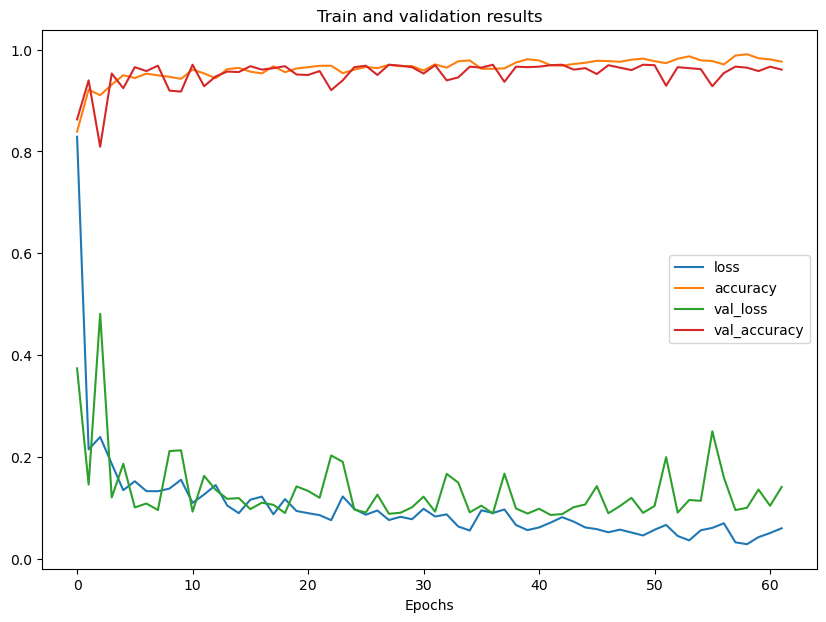

In [44]:
visualize_model_training(history.history)

### **2.4 Evaluate Performance**

Once our model is trained, we can test with real world data

In [73]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 23ms/step - loss: 1.0387 - accuracy: 0.7656
Test accuracy: 0.765625


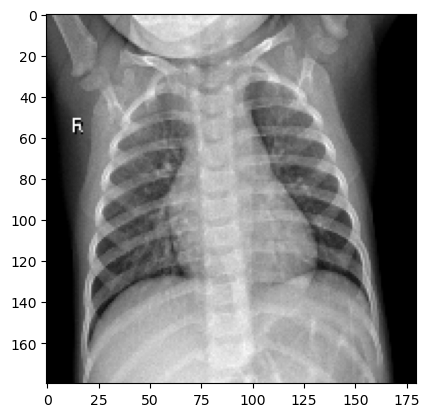

1/1 [==============================] - 0s 21ms/step
[[0.47631568 0.5236843 ]]
Predicted class is Pneumonia


In [68]:
import tkinter, cv2
from tkinter import filedialog

tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing

# pick image
img = cv2.imread(filedialog.askopenfile("r", filetypes=[('JPEG Files', '*.jpeg')], initialdir="./").name)
# convert the image to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Add an extra dimension for the channel
img = np.expand_dims(img, axis=-1)
# resize image
img = tf.image.resize(img, (180, 180)) 

plt.imshow(img.numpy().astype(int), cmap='gray')
plt.show()

img = img[np.newaxis, ...] # Add an extra dimension for the batch
ypred = model.predict(img/255, 1) # Add an extra dimension for the channel
print(ypred)

if ypred[0][1] > ypred[0][0]:
    print('Predicted class is Pneumonia')
else:
    print('Predicted class is Normal')

- True Positives (TP): These are the correctly predicted positive values which means that the value of the actual class is yes and the value of the predicted class is also yes.
- True Negatives (TN): These are the correctly predicted negative values which means that the value of the actual class is no and the value of the predicted class is also no.
- False Positives (FP): When the actual class is no and the predicted class is yes.
- False Negatives (FN): When the actual class is yes but the predicted class in no.

**Confusion matrix**:
- Diagnosing the quality of predictions: It gives us an insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.
- Understanding the misclassifications: It helps us understand which classes are most easily confused. This can be especially helpful for multi-class classification problems.
- Improving the model: Based on the confusion matrix, we might decide to increase the model complexity (e.g., the number of parameters), collect more data, or perhaps focus on specific features that could help distinguish certain classes.

In [3]:
from sklearn.metrics import confusion_matrix
# Get the model's predictions
def visualize_confusion_matrix(model):
    y_pred = model.predict(test_ds)

    # If your model outputs probabilities and you want to convert these probabilities into class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Now, extract the true labels from test_ds
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    # Print the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

20/20 [==============================] - 1s 25ms/step


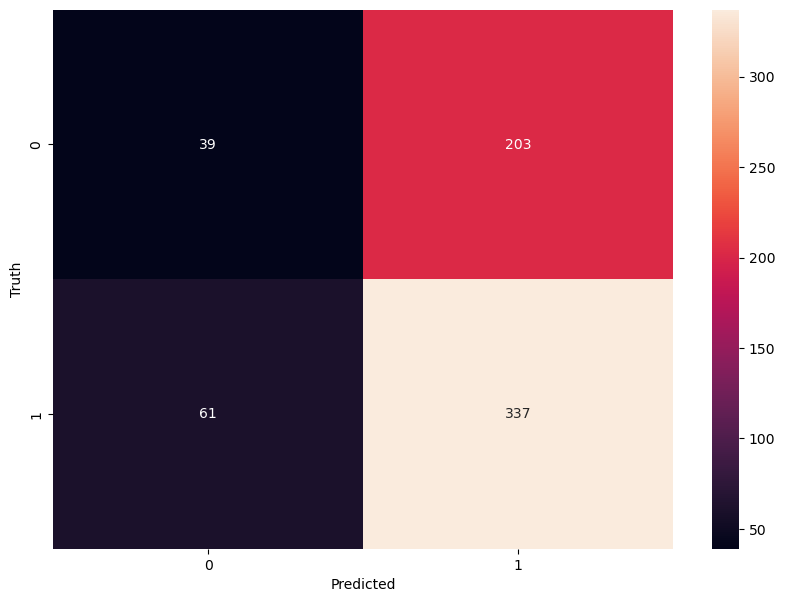

In [81]:
# Obtain the predictions
visualize_confusion_matrix(model)

### **2.5 Save and load the model**

In [6]:
from keras.models import load_model

In [88]:
folder = "./tf_models/MLP/"
# Save model
model.save(os.path.join(folder, "MLP.h5"))

# Save the history as a JSON file
with open(os.path.join(folder, "history.json"), 'w') as f:
    json.dump(history.history, f)

In [89]:
folder = "./tf_models/MLP/"

# Load the model
new_model = load_model(os.path.join(folder, "MLP.h5"))

# Load the history from the JSON file
with open(os.path.join(folder,"history.json"), 'r') as f:
    new_history = json.load(f)

## **3. Deep Model: Convolutional Neural Network (CNN)**

### **3.1 Build**

A Convolutional Neural Network (CNN) is a type of artificial neural network that is primarily used for image processing, classification, segmentation, and also for other auto-correlated data. A CNN has its artificial neurons arranged in three dimensions (width, height, depth) and uses the mathematical operation called convolution in place of general matrix multiplication in at least one of its layers.

Key components of CNNs include:

- **Convolutional layers**: These layers apply a series of filters to the input data to create a feature map or convolved feature.

- **Non-linearity (ReLU)**: ReLU stands for Rectified Linear Unit. It introduces non-linearity into the network, allowing the network to learn more complex features.

- **Pooling or subsampling layers**: Pooling reduces the spatial dimensions (width, height) of the input volume for the next convolutional layer. It also helps to reduce computation, and it provides a form of translation invariance in the feature representations.

- **Fully Connected layers**: Neurons in a fully connected layer connect to all outputs from the previous layer. This layer essentially determines the final output (e.g., classification into categories).

CNNs are particularly powerful at detecting patterns and structures in images due to their hierarchical architecture, which allows them to understand low-level features like edges and curves and then build up to understand high-level features like shapes, objects, or even faces in images.

![cnn](./images/a-cnn-sequence-to-classify-handwritten-digits.jpg)

In [7]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),

    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

- **layers.Conv2D**: This is a convolutional layer that performs 2D convolution on the input data. The main utility of this layer is to detect local features or patterns (such as edges, corners, and textures) in the input image. The parameters of this layer are:
    - `16`: The number of filters (or kernels) to be used in the convolution operation. This determines the number of feature maps that the layer will output.

    - `3`: The size of the filters (or kernels) used for the convolution. In this case, each filter is a 3x1 matrix. Smaller filter sizes are typically used to capture fine-grained features, while larger filter sizes capture more abstract or global features.

    - `activation='relu'`: The activation function applied to the output of the convolution operation. The Rectified Linear Unit (ReLU) activation function is commonly used in CNNs due to its ability to introduce non-linearity, speed up training, and mitigate the vanishing gradient problem.

- **layers.MaxPooling2D**: This is a pooling layer that performs 2D max pooling on the input data. The main utility of this layer is to reduce the spatial dimensions (height and width) of the input feature maps, which helps to:

    - Reduce the number of parameters in the network, making it computationally more efficient and less prone to overfitting.

    - Enhance the network's ability to capture more abstract features, as the pooling operation aggregates information from adjacent pixels.

    - Improve the network's translation invariance, as the pooling operation makes the network less sensitive to small translations in the input image.

In summary, the combination of the `Conv2D` layer and the `MaxPooling2D` layer allows the CNN to learn and extract hierarchical features from the input image while reducing the overall complexity of the network.


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### **3.2 Train**

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
131/131 [==============================] - 18s 135ms/step - loss: 0.2121 - accuracy: 0.9034 - val_loss: 0.1294 - val_accuracy: 0.9492
Epoch 2/100
131/131 [==============================] - 22s 168ms/step - loss: 0.1220 - accuracy: 0.9561 - val_loss: 0.0871 - val_accuracy: 0.9684
Epoch 3/100
131/131 [==============================] - 22s 170ms/step - loss: 0.1033 - accuracy: 0.9612 - val_loss: 0.0967 - val_accuracy: 0.9597
Epoch 4/100
131/131 [==============================] - 27s 202ms/step - loss: 0.0782 - accuracy: 0.9698 - val_loss: 0.1517 - val_accuracy: 0.9521
Epoch 5/100
131/131 [==============================] - 13s 97ms/step - loss: 0.0643 - accuracy: 0.9770 - val_loss: 0.0774 - val_accuracy: 0.9789
Epoch 6/100
131/131 [==============================] - 7s 54ms/step - loss: 0.0457 - accuracy: 0.9820 - val_loss: 0.1249 - val_accuracy: 0.9626
Epoch 7/100
131/131 [==============================] - 8s 56ms/step - loss: 0.0493 - accuracy: 0.9799 - val_loss: 0.0751 - val_

### **3.3 Model performance**

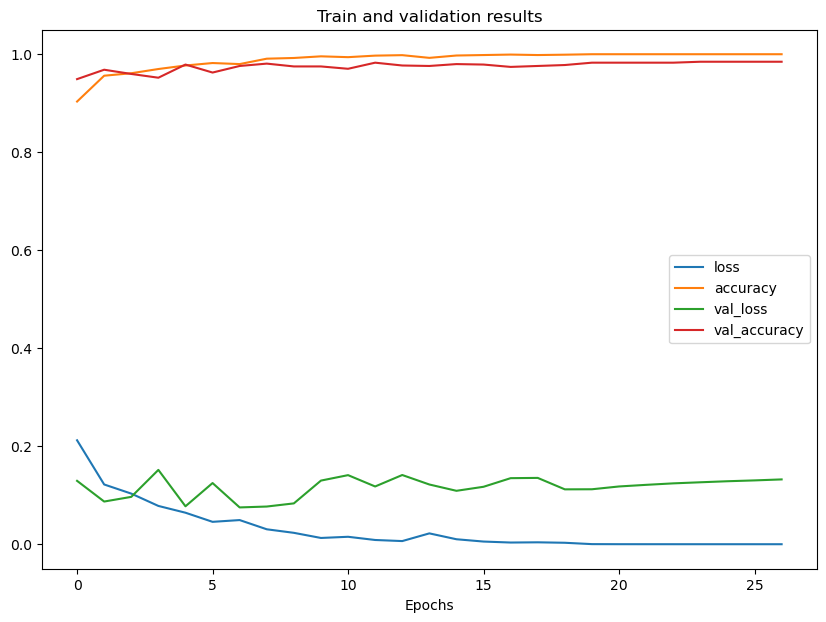

In [12]:
visualize_model_training(history.history)

### **3.4 Test**

In [13]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 22ms/step - loss: 0.9935 - accuracy: 0.7688
Test accuracy: 0.768750011920929


20/20 [==============================] - 1s 21ms/step


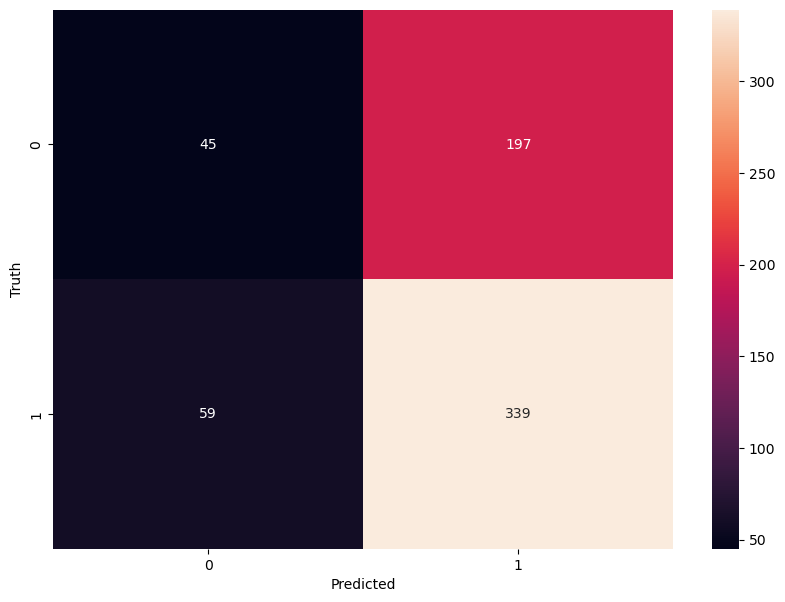

In [20]:
visualize_confusion_matrix(model)

### **3.5 Data augmentation**

Data augmentation is a strategy used to increase the diversity of data available for training models, without actually collecting new data. This technique helps to prevent overfitting and improve the performance of deep learning models.

Data augmentation techniques are applied to the training data, thereby augmenting it with new transformed versions of the original data. This means the model is exposed to more varied, but still relevant, data points during training, helping it to learn more robust, generalizable features.

In the context of images, these transformations can be:

- Flipping the image either horizontally or vertically.
- Rotating the image.
- Zooming in or out on the image.
- Cropping the image.
- Varying the color on the image.
- Translating the image either horizontally or vertically.

For us we have ~5000data, it is very poor. Data augmentation can be helpfull.

Keras contains it's own layer to apply data augmentation:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

But on tensorflow 2.10, it is bugged and slow the training. Instead of downgrade, we generated our data augmented images with ImageDataGenerator from tensorflow too.

Please check "data_augmentation.ipynb" notebook to generates the augmented images.

To have a good variation, we multiplied the number of data by 2

data size:
- NORMAL: 1341 * 2 = 2682
- PNEUMONIA: 3875 *2 = 7750

In total we have 10468 images in our test_ds

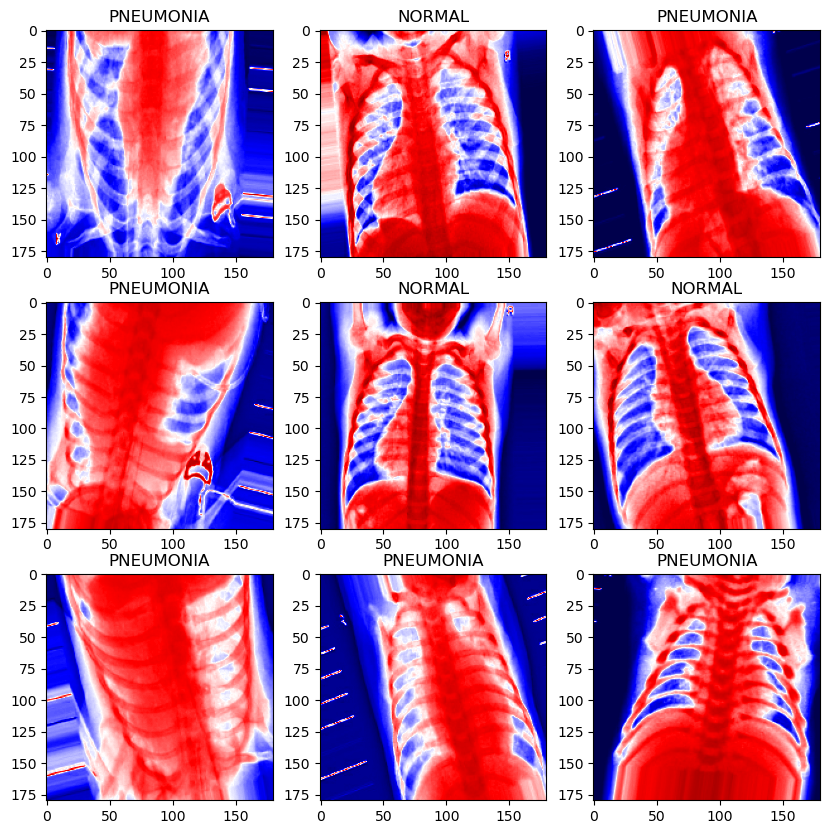

In [21]:
plt.figure(figsize=(10,10))
for images, labels in train_aug_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap="seismic") # cmap works only with grayscale
        plt.title(class_names[labels[i]])

In [22]:
# merge augmented data with real_data
train_ds = train_ds.concatenate(train_aug_ds)
val_ds = val_ds.concatenate(val_aug_ds)

In [23]:
# Retrain our last model with the used augmented ds
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
262/262 [==============================] - 10s 39ms/step - loss: 0.2339 - accuracy: 0.8983 - val_loss: 0.2418 - val_accuracy: 0.9185
Epoch 2/100
262/262 [==============================] - 9s 33ms/step - loss: 0.1783 - accuracy: 0.9274 - val_loss: 0.1610 - val_accuracy: 0.9391
Epoch 3/100
262/262 [==============================] - 8s 29ms/step - loss: 0.1391 - accuracy: 0.9426 - val_loss: 0.1525 - val_accuracy: 0.9386
Epoch 4/100
262/262 [==============================] - 8s 29ms/step - loss: 0.1154 - accuracy: 0.9540 - val_loss: 0.1577 - val_accuracy: 0.9382
Epoch 5/100
262/262 [==============================] - 8s 29ms/step - loss: 0.0881 - accuracy: 0.9667 - val_loss: 0.1543 - val_accuracy: 0.9420
Epoch 6/100
262/262 [==============================] - 8s 29ms/step - loss: 0.0681 - accuracy: 0.9747 - val_loss: 0.1894 - val_accuracy: 0.9334
Epoch 7/100
262/262 [==============================] - 9s 32ms/step - loss: 0.0451 - accuracy: 0.9832 - val_loss: 0.1944 - val_accuracy

In [24]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 19ms/step - loss: 0.6019 - accuracy: 0.8125
Test accuracy: 0.8125


20/20 [==============================] - 0s 14ms/step


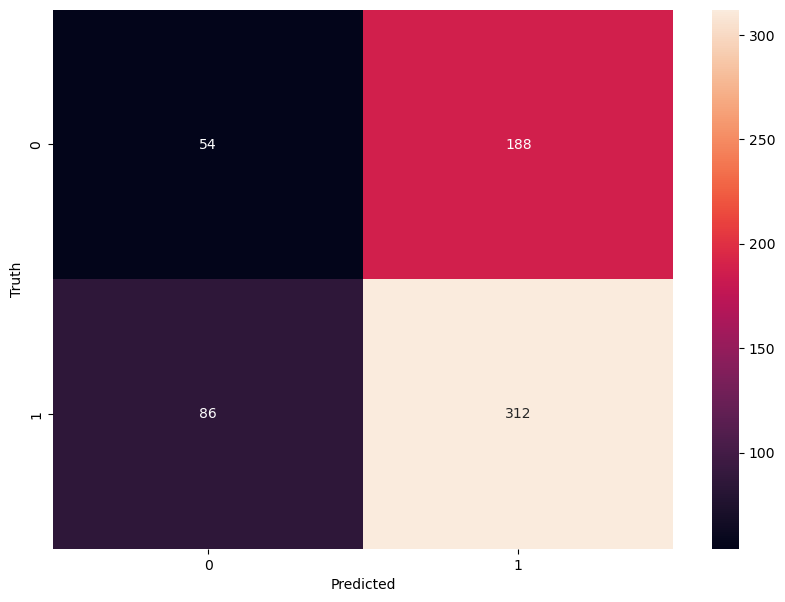

In [25]:
visualize_confusion_matrix(model)

In [ ]:
import tkinter, cv2
from tkinter import filedialog

tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing

# pick image
img = cv2.imread(filedialog.askopenfile("r", filetypes=[('JPEG Files', '*.jpeg')], initialdir="./").name)
# convert the image to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Add an extra dimension for the channel
img = np.expand_dims(img, axis=-1)
# resize image
img = tf.image.resize(img, (180, 180)) 

plt.imshow(img.numpy().astype(int), cmap='gray')
plt.show()

img = img[np.newaxis, ...] # Add an extra dimension for the batch
ypred = model.predict(img/255, 1) # Add an extra dimension for the channel
print(ypred)

if ypred[0][1] > ypred[0][0]:
    print('Predicted class is Pneumonia')
else:
    print('Predicted class is Normal')

DATA AUGMENTATION IS OP

In [26]:
folder = "./tf_models/CNN/"

# Save model
model.save(os.path.join(folder, "CNN.h5"))

# Save the history as a JSON file
with open(os.path.join(folder, "history.json"), 'w') as f:
    json.dump(history.history, f)

In [ ]:
folder = "./tf_models/MLP/"

# Load the model
new_model = load_model(os.path.join(folder, "MLP.h5"))

# Load the history from the JSON file
with open(os.path.join(folder,"history.json"), 'r') as f:
    new_history = json.load(f)

### **3.6 Tuning**

Our model is already 81% accurate, and it is not optimized. Each layer has parameters that can be modified.

Goal: find the best parameters to get a better model

A model with more layers is not the best.

#### **3.6.1 Manual searching**

In here, we created with bigger screen

The Dropout layer in a neural network is a form of regularization that helps to prevent overfitting. During training, the dropout layer randomly sets a fraction of input units to 0 at each update, which helps to prevent overfitting. This fraction is the rate, and it's a hyperparameter that can be tuned. For example, if the dropout rate is set to 0.5, approximately half of the input units are dropped out during training.

In [27]:
from keras import Input

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    layers.Rescaling(1./255),
    
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
262/262 [==============================] - 44s 156ms/step - loss: 0.3172 - accuracy: 0.8607 - val_loss: 0.2277 - val_accuracy: 0.9065
Epoch 2/100
262/262 [==============================] - 32s 122ms/step - loss: 0.2052 - accuracy: 0.9125 - val_loss: 0.2061 - val_accuracy: 0.9166
Epoch 3/100
262/262 [==============================] - 30s 113ms/step - loss: 0.1591 - accuracy: 0.9337 - val_loss: 0.1594 - val_accuracy: 0.9367
Epoch 4/100
262/262 [==============================] - 31s 119ms/step - loss: 0.1442 - accuracy: 0.9402 - val_loss: 0.1780 - val_accuracy: 0.9291
Epoch 5/100
262/262 [==============================] - 35s 135ms/step - loss: 0.1008 - accuracy: 0.9603 - val_loss: 0.1664 - val_accuracy: 0.9434
Epoch 6/100
262/262 [==============================] - 36s 137ms/step - loss: 0.0946 - accuracy: 0.9602 - val_loss: 0.1856 - val_accuracy: 0.9444
Epoch 7/100
262/262 [==============================] - 39s 149ms/step - loss: 0.0618 - accuracy: 0.9760 - val_loss: 0.2184 -

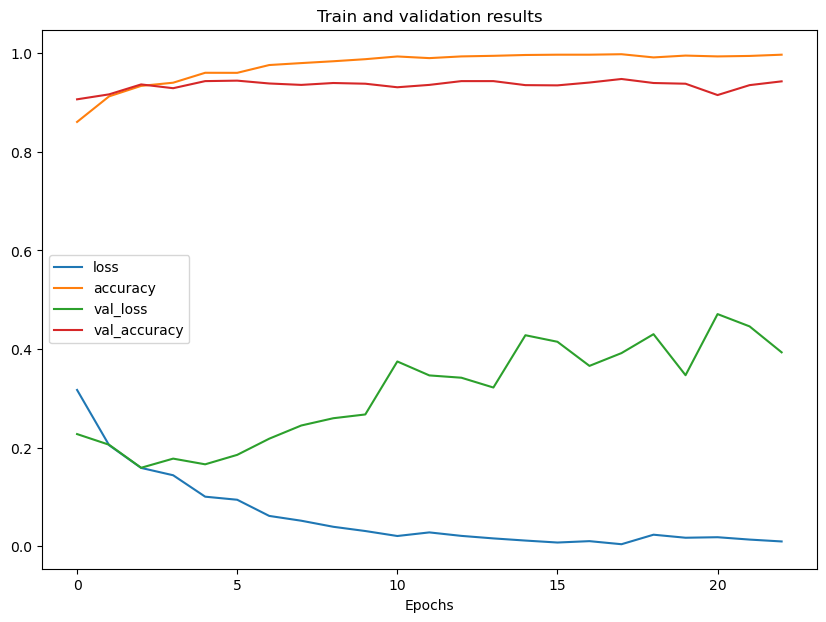

In [28]:
visualize_model_training(history.history)

In [18]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 3s 133ms/step - loss: 0.4871 - accuracy: 0.8359
Test accuracy: 0.8359375


20/20 [==============================] - 1s 40ms/step


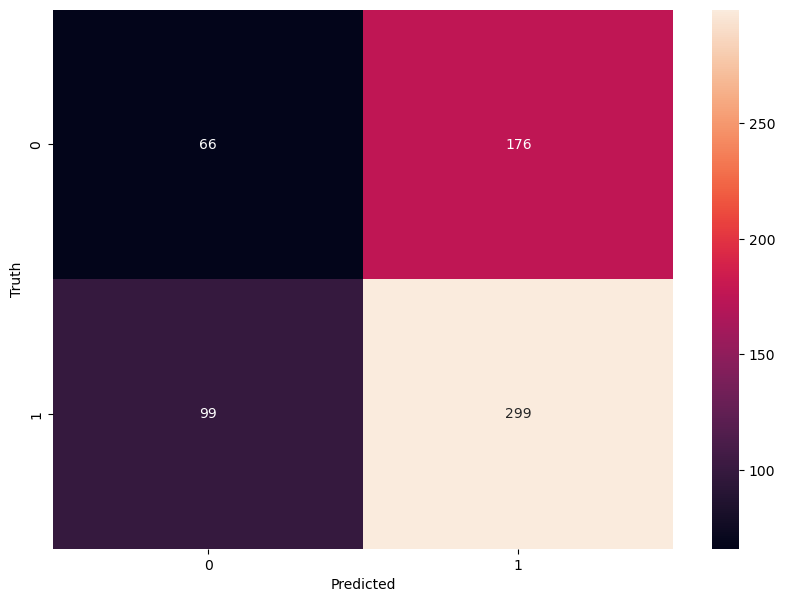

In [30]:
visualize_confusion_matrix(model)

Assuming that the rows of the matrix are the actual classes and columns are the predicted classes, the elements of the matrix represent the following:

- 66 (top left): True negatives - The cases in which your model correctly predicted the negative class. For example, the actual class was "NORMAL" and the model correctly predicted "NORMAL".
- 176 (top right): False positives - The cases in which your model incorrectly predicted the positive class. For example, the actual class was "NORMAL" but the model predicted "PNEUMONIA".
- 99 (bottom left): False negatives - The cases in which your model incorrectly predicted the negative class. For example, the actual class was "PNEUMONIA" but the model predicted "NORMAL".
- 299 (bottom right): True positives - The cases in which your model correctly predicted the positive class. For example, the actual class was "PNEUMONIA" and the model correctly predicted "PNEUMONIA".

So, for example, your model correctly predicted "NORMAL" 66 times and incorrectly predicted "NORMAL" 99 times. Similarly, it correctly predicted "PNEUMONIA" 299 times and incorrectly predicted "PNEUMONIA" 176 times.

In [31]:
folder = "./tf_models/best_CNN/"

# Save model
model.save(os.path.join(folder, "best_CNN.h5"))

# Save the history as a JSON file
with open(os.path.join(folder, "history.json"), 'w') as f:
    json.dump(history.history, f)

In [7]:
folder = "./tf_models/best_CNN/"

# Load the model
model = load_model(os.path.join(folder, "best_CNN.h5"))

# Load the history from the JSON file
with open(os.path.join(folder,"history.json"), 'r') as f:
    history = json.load(f)

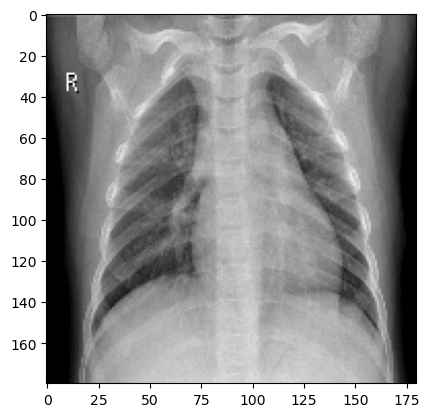

1/1 [==============================] - 0s 16ms/step
[[0.4374504 0.5625496]]
AI is 43.75% confident that the image belongs to NORMAL
AI is 56.25% confident that the image belongs to PNEUMONIA


In [26]:
import tkinter, cv2
from tkinter import filedialog

tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing

# pick image
img = cv2.imread(filedialog.askopenfile("r", filetypes=[('JPEG Files', '*.jpeg')], initialdir="./").name)
# convert the image to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Add an extra dimension for the channel
img = np.expand_dims(img, axis=-1)
# resize image
img = tf.image.resize(img, (180, 180)) 

plt.imshow(img.numpy().astype(int), cmap='gray')
plt.show()

img = img[np.newaxis, ...] # Add an extra dimension for the batch
ypred = model.predict(img/255, 1) # Add an extra dimension for the channel
print(ypred)

print(f'AI is {ypred[0][0]*100:.2f}% confident that the image belongs to NORMAL')
print(f'AI is {ypred[0][1]*100:.2f}% confident that the image belongs to PNEUMONIA')

# if ypred[0][1] > ypred[0][0]:
#     print('Predicted class is Pneumonia')
# else:
#     print('Predicted class is Normal')

#### **3.6.2 Automatize the search: keras_tuner**

The best model we got is the CNN with 64, 128, 256 layers but to faciliate, we can try to optimize this model by finding best parameter of the layers

In general, tuning the MaxPooling2D layers is not as crucial as tuning other hyperparameters like the number of filters, kernel size, or learning rate. MaxPooling2D layers are used to reduce the spatial dimensions of the feature maps and provide a form of translation invariance to the model. The most common pooling size used is (2, 2), which reduces the spatial dimensions by a factor of 2.

Random Search, Hyperband, and Bayesian Optimization are three different hyperparameter optimization methods used in machine learning to find the best model architecture and parameters.

- Random Search: Random Search is a simple and widely used method for hyperparameter optimization. In this method, hyperparameter combinations are sampled randomly from a predefined search space. The model is then trained and evaluated with each combination, and the best-performing combination is chosen. Random Search is computationally inexpensive but may require a large number of trials to find a good set of hyperparameters, especially in high-dimensional search spaces.

- Hyperband: Hyperband is an optimization method based on random search but with adaptive resource allocation and early stopping. It focuses on finding the best model with a limited budget of resources (like training time). The key idea behind Hyperband is to allocate more resources to the more promising models and stop training the less promising ones early. This is achieved by training models for varying numbers of epochs and adaptively allocating resources based on their performance. Hyperband is more efficient than Random Search as it can explore the search space more effectively by leveraging early stopping.

- Bayesian Optimization: Bayesian Optimization is a more advanced and efficient method for hyperparameter optimization. It uses a probabilistic model (usually a Gaussian Process) to model the objective function, which maps hyperparameter combinations to model performance. Based on the performance of previously evaluated models, it selects the next set of hyperparameters to try by optimizing an acquisition function that balances exploration (trying new hyperparameter combinations) and exploitation (focusing on known good combinations). Bayesian Optimization is more efficient than Random Search, as it uses prior knowledge about the performance of previous models to make informed decisions about which hyperparameter combinations to try next.


In summary, Random Search is the simplest method but may require more trials to find good hyperparameters. Hyperband improves upon Random Search by adaptively allocating resources and using early stopping, making it more efficient in finding good models within a limited budget. Bayesian Optimization is the most advanced method, using a probabilistic model to guide the search for optimal hyperparameters, often resulting in better model performance in fewer trials.

In [3]:
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
import copy

def build_model(hp):
    model = tf.keras.Sequential([
        layers.Input(shape=(img_height, img_width, 1)),
        layers.Rescaling(1./255),
        
        layers.Conv2D(
            filters=hp.Int("conv_1_filter", min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice("conv_1_kernel", values=[3, 5]),
            activation="relu"
        ),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(
            filters=hp.Int("conv_2_filter", min_value=32, max_value=256, step=16),
            kernel_size=hp.Choice("conv_2_kernel", values=[3, 5]),
            activation="relu"
        ),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(
            filters=hp.Int("conv_3_filter", min_value=32, max_value=256, step=16),
            kernel_size=hp.Choice("conv_3_kernel", values=[3, 5]),
            activation="relu"
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int("dense_units", min_value=32, max_value=128, step=16),
            activation="relu"
        ),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [4]:
from keras.callbacks import EarlyStopping

def create_early_stopping_callback():
    return EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.001,
        restore_best_weights=True
    )

In [6]:
# Initialize the Keras Tuner and set up the search space:
# tuner = RandomSearch(
#     build_model,
#     objective="val_accuracy",
#     max_trials=10,
#     executions_per_trial=3,
#     directory="output",
#     project_name="KerasTunerCNN"
# )

#Initialize the Keras Tuner and set up the search space:
tuner = BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=3,
    directory="output",
    project_name="KerasTunerCNN"
)


# find the best parameters
tuner.search(train_ds,
             epochs=100, # You can increase the maximum number of epochs since early stopping will halt training when there is no improvement
             callbacks=[create_early_stopping_callback()],
             validation_data=val_ds,
             steps_per_epoch=len(train_ds),
             validation_steps=len(val_ds))

Trial 20 Complete [00h 13m 58s]
val_accuracy: 0.9576541980107626

Best val_accuracy So Far: 0.9576541980107626
Total elapsed time: 04h 16m 43s
INFO:tensorflow:Oracle triggered exit


In [7]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(best_hyperparameters.values)

Best hyperparameters:
{'conv_1_filter': 32, 'conv_1_kernel': 3, 'conv_2_filter': 176, 'conv_2_kernel': 5, 'conv_3_filter': 176, 'conv_3_kernel': 5, 'dense_units': 96, 'learning_rate': 0.00011451155720572537}


In [8]:
# Test model with test dataset
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 31ms/step - loss: 0.9683 - accuracy: 0.8188
Test accuracy: 0.8187500238418579


Keras tuner takes a longer times.

## **4 Conclusion**

Scikit-learn is a very powerful library that provides a wide range of machine learning algorithms for both supervised and unsupervised learning, including tools for model selection and evaluation, data transformation, and data loading. It's an excellent choice for many machine learning tasks with structured data.

However, when it comes to image classification, deep learning models, specifically Convolutional Neural Networks (CNNs), have shown superior performance in most cases. This is because CNNs are designed to automatically and adaptively learn spatial hierarchies of features, which is ideal for image data. Libraries like TensorFlow and PyTorch, along with their high-level APIs like Keras, provide the necessary tools to design and train these kinds of models.

That said, scikit-learn can still be used for image classification tasks, particularly for smaller datasets or as a baseline model. Techniques like PCA for dimensionality reduction, SVMs for classification, and grid search for hyperparameter tuning can all be used effectively with image data in scikit-learn. However, for large-scale image classification tasks, deep learning models are generally a better choice.

In conclusion, while scikit-learn is an excellent library for many machine learning tasks, for image classification, you might achieve better results with a deep learning library like TensorFlow or PyTorch.